## Get results from the two fine-tuned models
This file compiles a number of predictions from a given starting frame, plotting the bounding boxes on the same frame.

In [268]:
import cv2, numpy as np, pathlib, re
from matplotlib import cm
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [ ]:
MODALITY  = 'event'
PROJECT   = Path(f'../runs/predict_{MODALITY}/predict')
K         = 100
START_IMG = '20_Video_20_frame_55466112.png'
OUTFILE   = f'track_{MODALITY}.jpg'

In [284]:
img_dir  = PROJECT / 'images'
if not img_dir.exists():
    img_dir = Path(f'../datasets/fred_{MODALITY}/images/test')

lbl_dir  = PROJECT / 'labels'

In [ ]:
def frame_number(name: str) -> int:
    m = re.search(r'_(\d+)(?:\.|$)', name)
    return int(m.group(1)) if m else -1

In [ ]:
clip_prefix = '_'.join(START_IMG.split('_')[:3])

def frame_key_rgb(name: str) -> float:
    parts = name.split('_')
    try:
        h, m, s = int(parts[-3]), int(parts[-2]), float(parts[-1].split('.')[0] + '.' + parts[-1].split('.')[1])
    except (IndexError, ValueError):
        return float('inf')
    return h * 3600 + m * 60 + s

def frame_key_event(name: str) -> int:
    m = re.search(r'_frame_(\d+)', name)
    return int(m.group(1)) if m else 0

if MODALITY == 'rgb':
    key_fn = lambda p: frame_key_rgb(p.stem)
else:
    key_fn = lambda p: frame_key_event(p.stem)

all_imgs = sorted([p for p in img_dir.iterdir()
                   if p.name.startswith(clip_prefix)],
                  key=key_fn)

idx = next(i for i, p in enumerate(all_imgs) if p.name == START_IMG)

frames = all_imgs[max(0, idx-K+1):idx+1]

print(f'{len(all_imgs)} images were found in total')
print(f'{len(frames)} relevant images were found')

3499 images were found in total
100 relevant images were found


In [ ]:
canvas = cv2.imread(str(frames[-1]))
H, W   = canvas.shape[:2]

In [294]:
colors = (cm.get_cmap('Reds', K+1)(np.arange(K+1))[:, :3] * 255).astype(int)

/tmp/ipykernel_25173/4274170318.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = (cm.get_cmap('Reds', K+1)(np.arange(K+1))[:, :3] * 255).astype(int)


In [ ]:
detections = 0
for age, f in enumerate(frames):
    label = lbl_dir / (f.stem + '.txt')
    if not label.exists():
        continue 
    detections += 1
    boxes = np.loadtxt(label, ndmin=2)
    for _, x, y, w, h, c in boxes:
        x1 = int((x - w/2) * W)
        y1 = int((y - h/2) * H)
        x2 = int((x + w/2) * W)
        y2 = int((y + h/2) * H)
        c  = tuple(int(v) for v in colors[K-age])
        cv2.rectangle(canvas, (x1, y1), (x2, y2), c, 2)

print(f'There were {detections} detections.')

There were 100 detections.


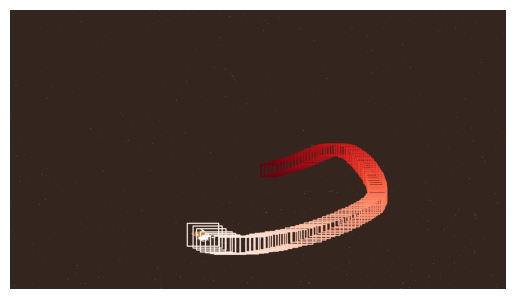

In [296]:
plt.axis('off')
plt.imshow(canvas)

In [297]:
cv2.imwrite(OUTFILE, canvas)
print(f'Saved {OUTFILE}')

Saved track_event.jpg
